In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/denoise-image-report/output-image.png
/kaggle/input/n2n-gaussian/network_final-gaussian-n2n.pickle
/kaggle/input/denoise-train-1/test_b.png
/kaggle/input/denoise-test/test_a.png


In [5]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


In [10]:
!pip install n2v csbdeep urllib3 tifffile


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.1/500.1 kB 28.1 MB/s eta 0:00:00


In [5]:
# !pip install tensorflow-gpu


  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      Traceback (most recent call last):
        File "<string>", line 36, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-bmne4q1g/tensorflow-gpu_8d3c71c066754d16a1deae37e3b23cd9/setup.py", line 37, in <module>
          raise Exception(TF_REMOVAL_WARNING)
      Exception:
      
      The "tensorflow-gpu" package has been removed!
      
      Please install "tensorflow" instead.
      
      Other than the name, the two packages have been identical
      since TensorFlow 2.1, or roughly since Sep 2019. For more
      information, see: pypi.org/project/tensorflow-gpu
      
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
  Runnin

In [6]:
# import tensorflow as tf
# print(tf.config.list_physical_devices('GPU'))


In [12]:
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile
from tifffile import imread
from csbdeep.io import save_tiff_imagej_compatible

import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [11]:
#Loading Training data
import imageio

data = imageio.imread('/kaggle/input/denoise-train-1/test_b.png')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  import sys


In [12]:
print(data.shape)

(5454, 6330)


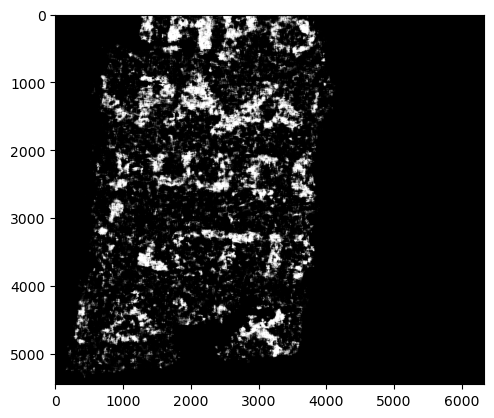

In [13]:
plt.imshow(data, cmap='gray')
plt.show()

**Training Data Preparation**

In [14]:
datagen = N2V_DataGenerator()

In [15]:
# imgs = datagen.load_imgs_from_directory(directory = "data/", dims="TYX")
imgs=imageio.imread('/kaggle/input/denoise-train-1/test_b.png')
print(imgs.shape)
print(len(imgs))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  


(5454, 6330)
5454


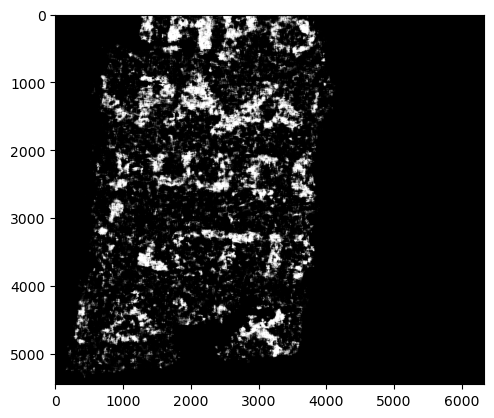

In [16]:
# Lets' look at the images.
# Select channel=0 in the last dimension, as `imshow()` doesn't really understand channels
plt.imshow(imgs, cmap='gray')
plt.show()

(1, 3000, 3200, 1)


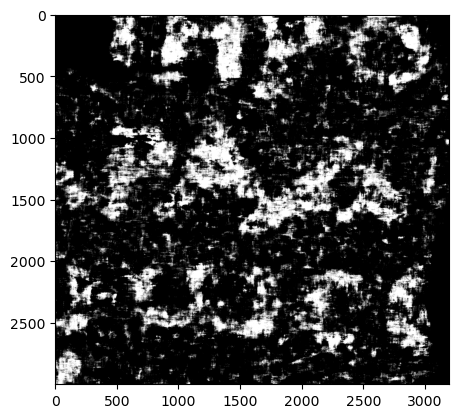

Generated patches: (4600, 128, 128, 1)
(1, 2454, 3200, 1)


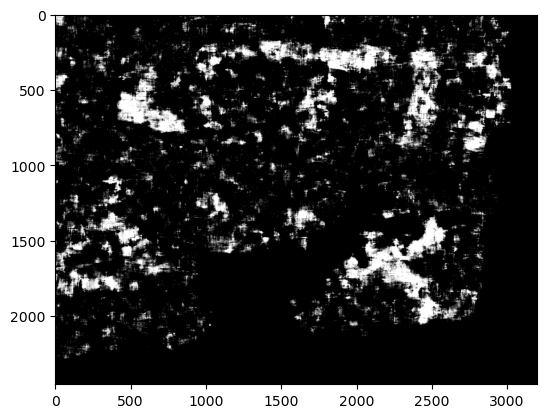

Generated patches: (3800, 128, 128, 1)


In [17]:
# split up image into little non-overlapping patches for training.
# x<3000 (top of image) is training, x>=3000 (bottom of image) is validation
imgs_train = [imgs[np.newaxis,:3000,800:4000,np.newaxis]]
print(imgs_train[0].shape)

plt.imshow(imgs_train[0][0,...,0], cmap='gray')
plt.show()
X = datagen.generate_patches_from_list(imgs_train,shape=(128,128))
imgs_vali = [imgs[np.newaxis,3000:,800:4000,np.newaxis]]
print(imgs_vali[0].shape)

plt.imshow(imgs_vali[0][0,...,0], cmap='gray')
plt.show()
X_val = datagen.generate_patches_from_list(imgs_vali,shape=(128,128))


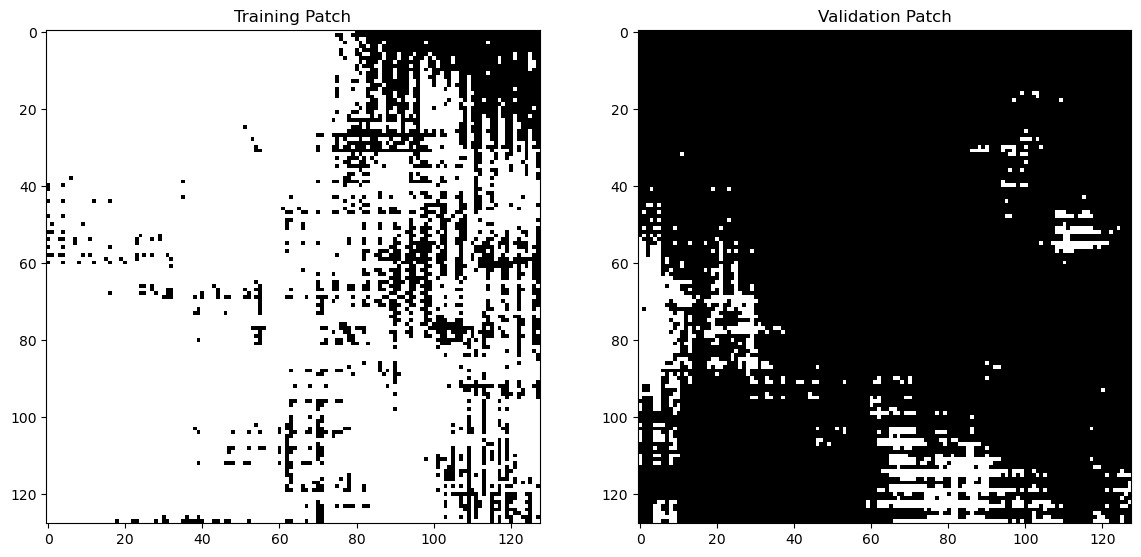

In [18]:
# Let's look at one of our training and validation patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[1000,...,0], cmap='gray')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[755,...,0], cmap='gray')
plt.title('Validation Patch');

In [19]:
# train_steps_per_epoch is set to (number of training patches)/(batch size), like this each training patch 
# is shown once per epoch. 
config = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=int(X.shape[0]/(16)), train_epochs=2, train_loss='mse', batch_norm=True, 
                   train_batch_size=128, n2v_perc_pix=0.198, n2v_patch_shape=(128, 128), 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5, structN2Vmask = [[0,1,1,1,1,1,1,1,1,1,0]])

# Let's look at the parameters stored in the config-object.
vars(config)

{'means': ['48.07291896654212'],
 'stds': ['99.73759972299526'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'unet_residual': False,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 2,
 'train_steps_per_epoch': 287,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (128, 128),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'single_net_per_channel': True,
 'blurpool': False,
 'skip_skipone': False,
 'structN2Vmask': [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]],
 'probabilistic': False}

**Training**
Training the model will likely take some time. We recommend to monitor the progress with TensorBoard, which allows you to inspect the losses during training. Furthermore, you can look at the predictions for some of the validation images, which can be helpful to recognize problems early on.

In [20]:
# a name used to identify the model
model_name = 'n2v_2D_ink_denoise'
# the base directory in which our model will live
basedir = '/kaggle/working/models-ink'
# We are now creating our network model.
model = N2V(config, model_name, basedir=basedir)

/opt/conda/lib/python3.7/site-packages/n2v/models/n2v_standard.py:430: UserWarning: output path for model already exists, files may be overwritten: /kaggle/working/models-ink/n2v_2D_ink_denoise
  'output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


In [21]:
# We are ready to start training now.
history = model.train(X, X_val)

StructN2V Mask is:  [[0 1 1 1 1 1 1 1 1 1 0]]
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|██████████| 3800/3800 [00:05<00:00, 696.90it/s]


Epoch 1/2
287/287 [==============================] - 7224s 25s/step - loss: 0.3035 - n2v_mse: 0.3035 - n2v_abs: 0.2737 - val_loss: 0.5086 - val_n2v_mse: 0.5086 - val_n2v_abs: 0.6210 - lr: 4.0000e-04
Epoch 2/2
287/287 [==============================] - 7043s 25s/step - loss: 0.2491 - n2v_mse: 0.2491 - n2v_abs: 0.2245 - val_loss: 0.3596 - val_n2v_mse: 0.3595 - val_n2v_abs: 0.4905 - lr: 4.0000e-04

Loading network weights from 'weights_best.h5'.


**After training, lets plot training and validation loss.**

['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


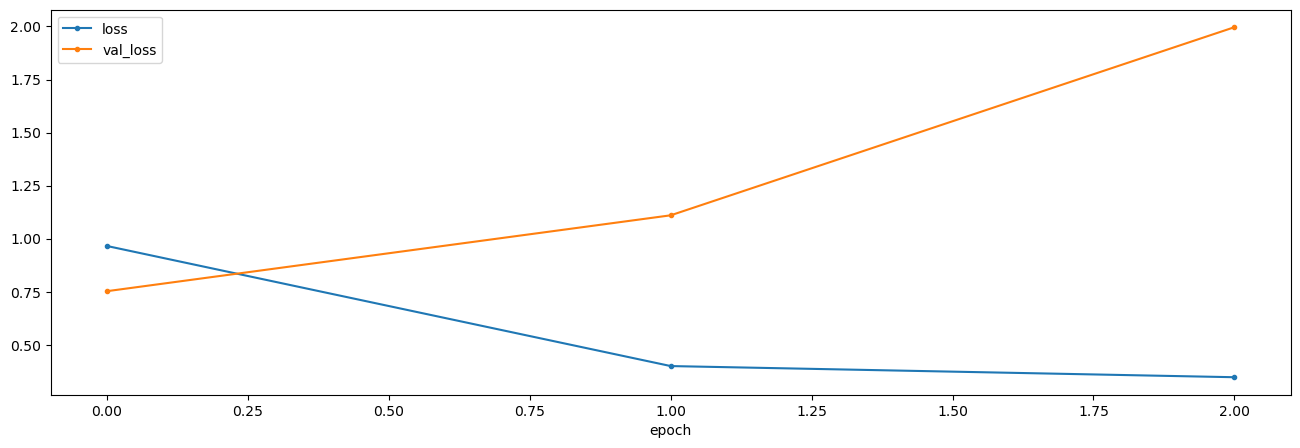

In [21]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

In [23]:
# # Save the model to a file
# model.keras_model.save_weights('test-model.h5')

Export Model in BioImage ModelZoo Format

In [13]:
# A previously trained model is loaded by creating a new N2V-object without providing a 'config'.
model_name = 'n2v_2D_ink_denoise'
basedir = '/kaggle/working/models-ink'
model = N2V(config=None, name=model_name, basedir=basedir)

Loading network weights from 'weights_best.h5'.


In [14]:
model.config.axes='YXC'

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  This is separate from the ipykernel package so we can avoid doing imports until


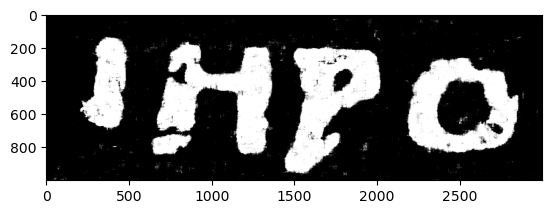

The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 8s 8s/step


In [15]:
# We load the data we want to process.
import imageio
input_train=imageio.imread('/kaggle/input/denoise-image-report/output-image.png')
# print(input_train[:2].shape)
input_train=input_train[np.newaxis,:,:,np.newaxis]

plt.imshow(input_train[0,...,0], cmap='gray')
plt.show()
# print(input_train[0].shape)

# Here we process the data.
# The parameter 'n_tiles' can be used if images are to big for the GPU memory.
# If we do not provide the n_tiles' parameter the system will automatically try to find an appropriate tiling.
# This can take longer.
pred_train = []
for _x in input_train:
    _yp = model.predict(_x, axes='YXC', n_tiles=(1,1,1))
    pred_train.append(_yp)
pred_train = np.array(pred_train)

# We load and process the data we previously used for validation.
# input_val = imread('data/validation.tif')
# pred_val = model.predict(input_val, axes='TYX')

In [16]:
print(pred_train[0,:100,:100,0])

[[  6.460697    7.235035    6.476658  ...   2.8359222   2.8359222
    2.8359222]
 [  0.8108635  -0.5730171   2.9384308 ...  -3.1988335  -3.1988335
   -3.1988335]
 [  1.7367401 -10.073761   -6.5824776 ... -20.448788  -20.448788
  -20.448788 ]
 ...
 [ -7.7613907 -16.651531  -13.724712  ... -60.15003   -60.15003
  -60.15003  ]
 [ -7.7613907 -16.651531  -13.724712  ... -60.15003   -60.15003
  -60.15003  ]
 [ -7.7613907 -16.651531  -13.724712  ... -60.15003   -60.15003
  -60.15003  ]]


[[0.19907875 0.2010401  0.19911918 ... 0.18989736 0.18989736 0.18989736]
 [0.18476799 0.18126267 0.19015701 ... 0.17461161 0.17461161 0.17461161]
 [0.18711318 0.15719774 0.166041   ... 0.13091828 0.13091828 0.13091828]
 ...
 [0.16305487 0.14053655 0.14795005 ... 0.0303569  0.0303569  0.0303569 ]
 [0.16305487 0.14053655 0.14795005 ... 0.0303569  0.0303569  0.0303569 ]
 [0.16305487 0.14053655 0.14795005 ... 0.0303569  0.0303569  0.0303569 ]]
[[  6.460697    7.235035    6.476658  ...   2.8359222   2.8359222
    2.8359222]
 [  0.8108635  -0.5730171   2.9384308 ...  -3.1988335  -3.1988335
   -3.1988335]
 [  1.7367401 -10.073761   -6.5824776 ... -20.448788  -20.448788
  -20.448788 ]
 ...
 [ -7.7613907 -16.651531  -13.724712  ... -60.15003   -60.15003
  -60.15003  ]
 [ -7.7613907 -16.651531  -13.724712  ... -60.15003   -60.15003
  -60.15003  ]
 [ -7.7613907 -16.651531  -13.724712  ... -60.15003   -60.15003
  -60.15003  ]]


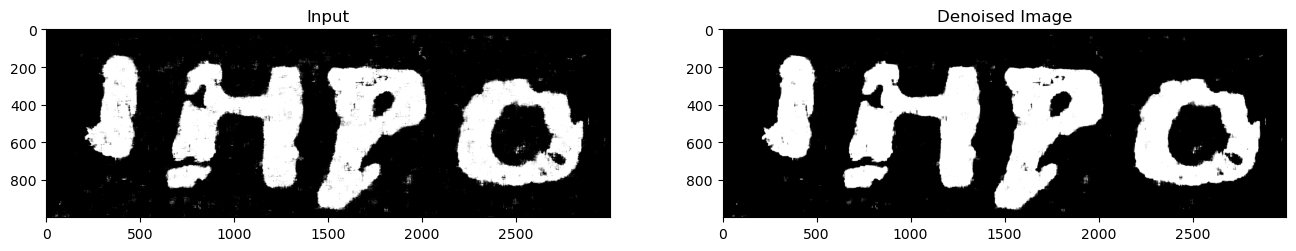

In [18]:
# Let's look at the results.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_pred_train = scaler.fit_transform(pred_train.reshape(-1, 1)).reshape(pred_train.shape)

threshold = 0.5
binary_pred_train = (scaled_pred_train[0,...,0] > threshold).astype(np.uint8)
# binary_pred_train = pred_train[0,...,0] 

print(scaled_pred_train[0,:100,:100,0])
print(pred_train[0,:100,:100,0])
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(input_train[0,...,0],cmap="gray")
plt.title('Input');
plt.subplot(1,2,2)
plt.imshow(binary_pred_train,cmap="gray")
plt.title('Denoised Image');


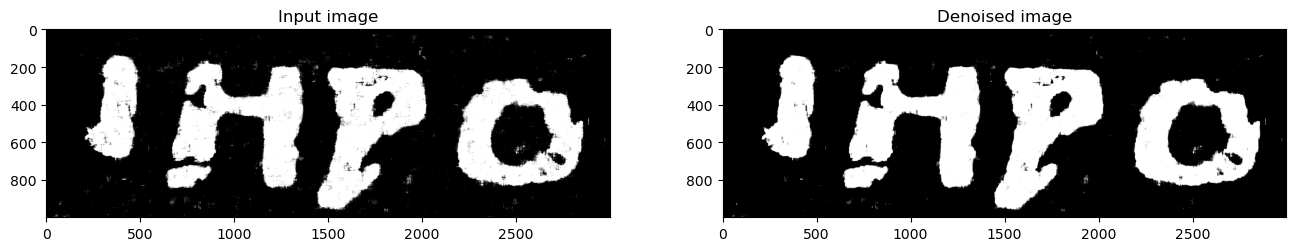

In [19]:
# Let's look at the results.

scaler = MinMaxScaler()
scaled_pred_train = scaler.fit_transform(pred_train.reshape(-1, 1)).reshape(pred_train.shape)

threshold = 0.5
binary_pred_train = (scaled_pred_train[0,...,0] > threshold).astype(np.uint8)
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(input_train[0,...,0],cmap="gray")
plt.title('Input image');
plt.subplot(1,2,2)
plt.imshow(binary_pred_train,cmap="gray")
plt.title('Denoised image');

In [20]:
save_tiff_imagej_compatible('pred.tif', pred_train, axes='TYXC')

In [34]:
!zip -r models-ink.zip /kaggle/working/models-ink


updating: kaggle/working/models-ink/ (stored 0%)
updating: kaggle/working/models-ink/n2v_2D_ink_denoise/ (stored 0%)
updating: kaggle/working/models-ink/n2v_2D_ink_denoise/config.json (deflated 47%)
updating: kaggle/working/models-ink/n2v_2D_ink_denoise/logs/ (stored 0%)
updating: kaggle/working/models-ink/n2v_2D_ink_denoise/logs/validation/ (stored 0%)
updating: kaggle/working/models-ink/n2v_2D_ink_denoise/logs/validation/events.out.tfevents.1683002918.81e6d19359f5.27.2.v2 (deflated 50%)
updating: kaggle/working/models-ink/n2v_2D_ink_denoise/logs/validation/events.out.tfevents.1683005205.d8f2124ff0dd.27.2.v2 (deflated 75%)
updating: kaggle/working/models-ink/n2v_2D_ink_denoise/logs/images/ (stored 0%)
updating: kaggle/working/models-ink/n2v_2D_ink_denoise/logs/images/events.out.tfevents.1683005103.d8f2124ff0dd.27.0.v2 (deflated 2%)
updating: kaggle/working/models-ink/n2v_2D_ink_denoise/logs/images/events.out.tfevents.1683002825.81e6d19359f5.27.0.v2 (deflated 8%)
updating: kaggle/worki